# Pressure: An Observational Study 😨

Hypothesis: Higher pressure situations lessen the likelihood of field goal conversion.

In [19]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import mysql.connector
import itertools
import dtale
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
from datetime import datetime as dt
from util.data import clean, get_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load & Clean

In [20]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
2166,AD-0800,1,38,2000,17,73,BUF,Ralph Wilson Stadium,TEN,0,...,1,10,1,0,0,1,0,1,0.764708,765
2185,AD-0800,1,27,2000,17,73,BUF,Ralph Wilson Stadium,TEN,0,...,1,10,1,0,0,1,0,1,0.807721,766
4565,AD-0800,1,36,2000,17,80,TEN,Adelphia Coliseum,TEN,0,...,1,13,0,0,1,0,0,5,0.842837,767
8564,AD-0800,1,24,2000,17,61,PIT,Three Rivers Stadium,TEN,0,...,0,16,1,0,0,1,1,1,0.842837,768
8628,AD-0800,1,40,2000,17,61,PIT,Three Rivers Stadium,TEN,0,...,0,16,1,0,0,1,1,1,0.871516,769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862982,ZG-0050,1,30,2019,3,66,ARI,State Farm Stadium,ARI,0,...,0,0,0,0,0,0,0,1,0.826709,62
865338,ZG-0050,1,21,2019,3,66,ARI,State Farm Stadium,ARI,0,...,0,11,0,0,0,0,0,2,0.858217,63
868268,ZG-0050,1,22,2019,3,43,SEA,CenturyLink Field,ARI,0,...,1,7,1,0,0,1,0,1,1.000000,64


## Explore

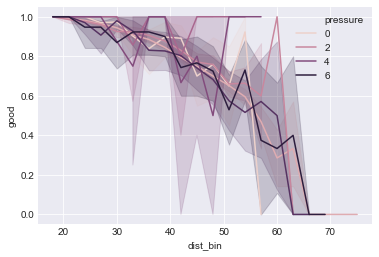

In [21]:
df_ = df.copy()
df_['dist_bin'] = 3*round(df_['dist']/3)
sns.lineplot(x='dist_bin', y='good', hue='pressure', data=df_)

In [22]:
df = df[df['dist']>=40].drop(['fkicker', 'home_team', 'stadium', 'team', 'XP', 'humid'], axis=1)
df.dropna(inplace=True)
df

,good,dist,year,seasons,temperature,age,altitude,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,
8628,1,40,2000,17,61,38,0,16,1,0,0,1,1,1,0.871516,769
8652,1,40,2000,17,61,38,0,16,1,0,0,1,1,2,0.894946,770
11064,0,46,2000,17,72,38,0,5,0,0,1,0,0,1,1.000000,771
12417,1,41,2000,17,44,38,0,10,1,0,0,0,0,1,0.842957,773
16254,0,44,2000,17,74,38,0,6,0,0,0,0,0,1,0.671096,777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844674,1,47,2019,3,56,24,0,3,1,0,0,1,1,1,0.813096,52
846996,1,50,2019,3,70,24,0,0,1,0,0,1,0,1,0.771461,56
851666,1,54,2019,3,77,24,0,8,1,0,0,0,0,1,0.883073,59


1    5880
2    1379
5     295
6     201
0     160
3      15
4      15
Name: pressure, dtype: int64


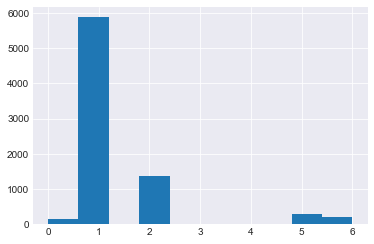

In [23]:
print(df['pressure'].value_counts())
df['pressure'].hist()

The distribution is very skewed. It may be necessary to collapse some of the categories. \[0,1\],\[2,3,4\],\[5,6\] (i.e. low, medium, high pressure)

In [24]:
df['pressure'] = df['pressure'].map({0:0, 1:0, 2:1, 3:1, 4:1, 5:2, 6:2})
print(df['pressure'].value_counts())

0    6040
1    1409
2     496
Name: pressure, dtype: int64


## Matching

* Mahalanobis distance with radius matching
* We need to perform balance measurements to check the marginal distributions of each covariate are satisfactorily similar.
* Marginal because multi-dimensional histograms are very coarse.

In [25]:
from util.matching import mahalanobis_frontier, match_by_distance
df['pressure_bool'] = df['pressure'].astype(bool)
df_mf = mahalanobis_frontier(df.drop(['good', 'pressure'], axis=1), 'pressure_bool')
df_mf

127 distances to check.
Checked 1/127 distances
Checked 11/127 distances
Checked 21/127 distances
Checked 31/127 distances
Checked 41/127 distances
Checked 51/127 distances
Checked 61/127 distances
Checked 71/127 distances
Checked 81/127 distances
Checked 91/127 distances
Checked 101/127 distances
Checked 111/127 distances
Checked 121/127 distances


,pruned controls,pruned treatments,AMD,radius
0,0,0,1.372550,12.9
1,0,0,1.372550,12.8
2,0,0,1.372550,12.5
3,0,0,1.372550,12.4
4,0,0,1.372550,12.3
...,...,...,...,...
122,5933,1801,0.258078,0.4
123,5967,1835,0.216329,0.3
124,6021,1887,0.116404,0.2
125,6033,1898,0.052507,0.1


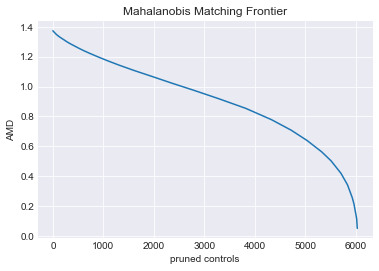

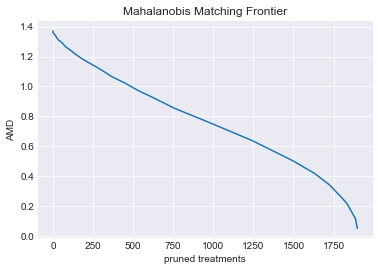

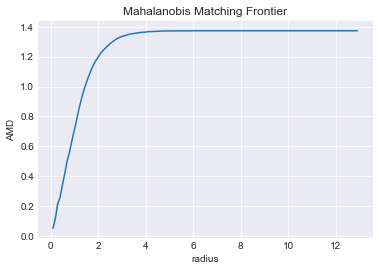

In [26]:
sns.lineplot(x='pruned controls', y='AMD', data=df_mf)
plt.title('Mahalanobis Matching Frontier')
plt.show()
plt.title('Mahalanobis Matching Frontier')
sns.lineplot(x='pruned treatments', y='AMD', data=df_mf)
plt.show()
plt.title('Mahalanobis Matching Frontier')
sns.lineplot(x='radius', y='AMD', data=df_mf)

It's not immediately obvious where to put the threshold. We have some high pressure examples to spare so we choose a relatively tight radius of 0.8.

In [47]:
df_matched = match_by_distance(df.drop('pressure', axis=1), 'pressure_bool', 'good', 'mahalanobis', 1).drop('pressure_bool', axis=1)
df_matched['pressure'] = df['pressure']

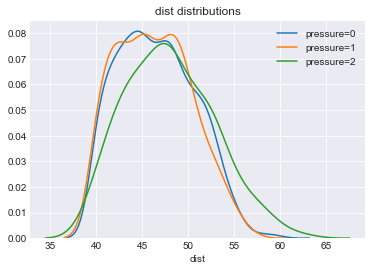

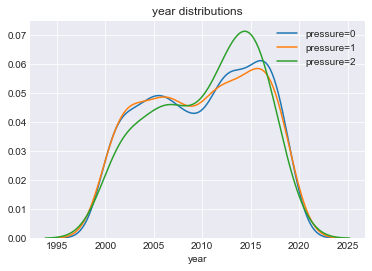

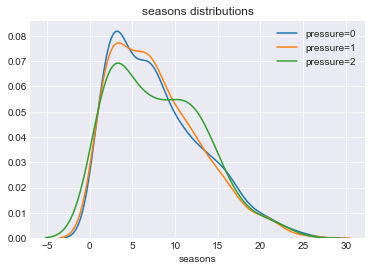

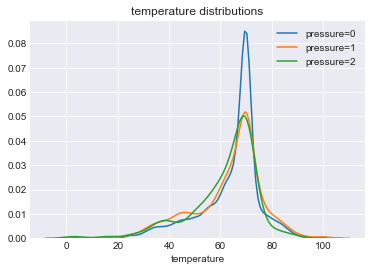

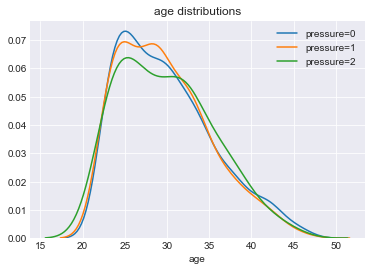

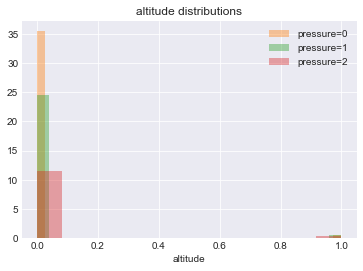

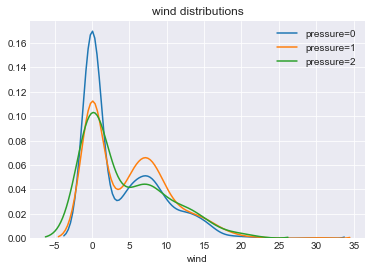

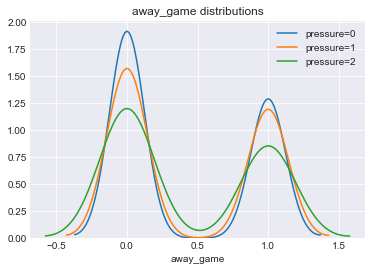

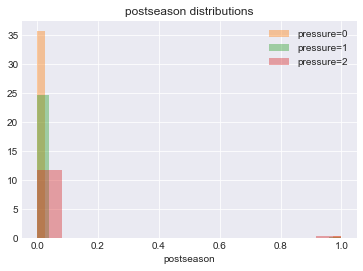

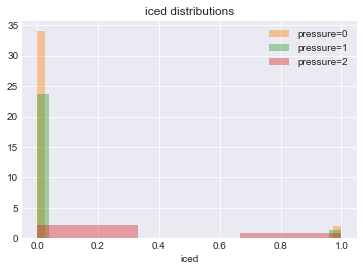

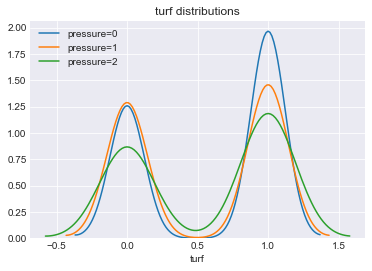

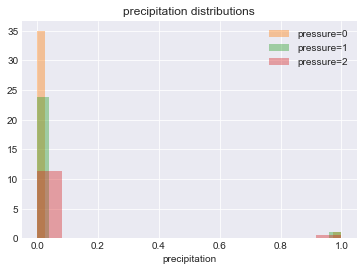

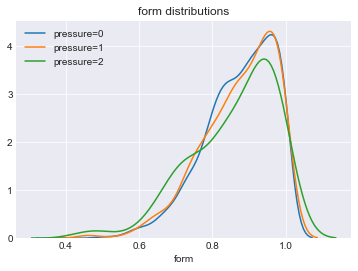

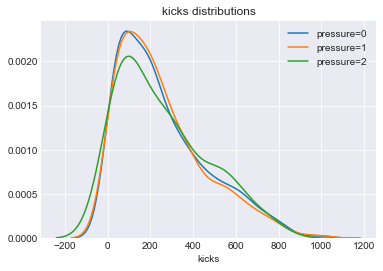

In [48]:
from util.matching import covariate_dists
covariate_dists(df_matched.drop('good', axis=1), on='pressure')

In [49]:
df_low = df_matched.loc[df_matched['pressure']==0, :]
df_med = df_matched.loc[df_matched['pressure']==1, :]
df_high = df_matched.loc[df_matched['pressure']==2, :]
print(len(df_low), 'low-pressure samples.', len(df_med), 'medium-pressure samples.', len(df_high), 'high-pressure samples.')

1317 low-pressure samples. 667 medium-pressure samples. 149 high-pressure samples.


## Model

We work within a Bayesian framework, setting a prior distribution on the true population proportion and update the prior after our observations. The Beta-Binomial conjugacy makes this process relatively pain-free.

In [50]:
from scipy.stats import beta
p_hat = df[df['dist']>=40]['good'].mean()
alpha_ = 10
beta_ = int(round(alpha_*(1-p_hat)/p_hat))
print(f'alpha: {alpha_}, beta: {beta_}')

alpha: 10, beta: 4


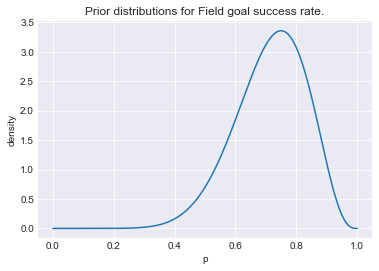

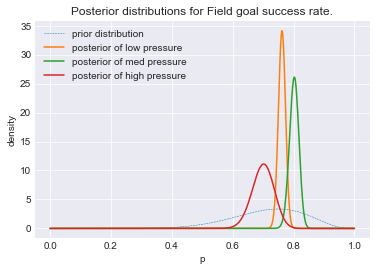

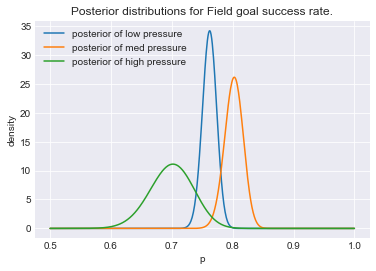

In [51]:
from util.bayes import BetaBinomial

# setup random variables
low = BetaBinomial(alpha_, beta_, 'low pressure')
medium = BetaBinomial(alpha_, beta_, 'med pressure')
high = BetaBinomial(alpha_, beta_, 'high pressure')
low.plot_prior(show=True)
plt.cla()

# update prior
low.observe(df_low['good'])
medium.observe(df_med['good'])
high.observe(df_high['good'])

# plot posterior
low.plot_posterior(prior=True)
medium.plot_posterior(prior=False)
high.plot_posterior(prior=False, show=True)

# zoom in
x = np.linspace(0.5,1,500)
low.plot_posterior(x, prior=False)
medium.plot_posterior(x, prior=False)
high.plot_posterior(x, prior=False, show=True)

# sample from posterior
samples = 20000
samples_posterior_low = low.sample(samples)
samples_posterior_med = medium.sample(samples)
samples_posterior_high = high.sample(samples)

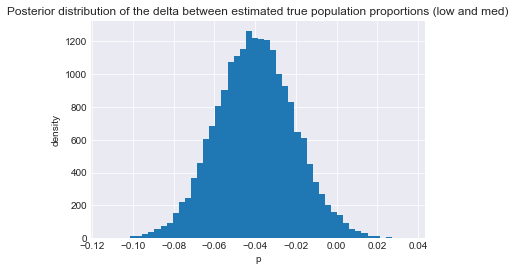

97 % likely that low pressure has a lower true population proportion of converted field goals than medium pressure.
-0.04 is the median difference, with a 50% credible interval of (0.0,-0.08).


In [52]:
posterior_diff = samples_posterior_low - samples_posterior_med

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions (low and med)')
plt.show()
print(int((samples_posterior_low<samples_posterior_med).mean()*100), r'% likely that low pressure has a lower true population proportion of converted field goals than medium pressure.')

from scipy.stats import bayes_mvs
alpha = 0.5
center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with a {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

95 % likely relative lift of medium over low pressure kicks greater than 1%.
0.05 is the median relative lift, with a 50% credible interval of (0.0,0.11).


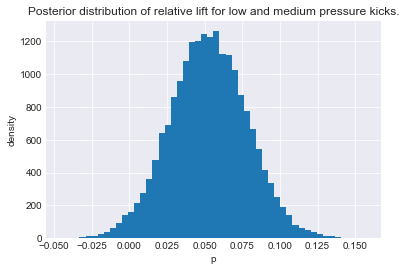

In [53]:
posterior_relative = (samples_posterior_med-samples_posterior_low)/samples_posterior_low
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of relative lift for low and medium pressure kicks.')
print(int((posterior_relative>0.01).mean()*100), r'% likely relative lift of medium over low pressure kicks greater than 1%.')

center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with a {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

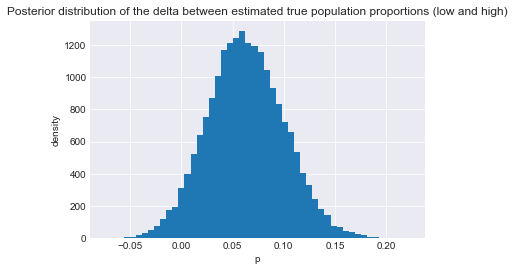

95 % likely that low pressure has a higher true population proportion of converted field goals than high pressure.
0.06 is the median difference, with a 50% credible interval of (0.0,0.13).


In [54]:
posterior_diff = samples_posterior_low - samples_posterior_high

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions (low and high)')
plt.show()
print(int((samples_posterior_low>samples_posterior_high).mean()*100), r'% likely that low pressure has a higher true population proportion of converted field goals than high pressure.')

center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with a {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

93 % likely relative lift of low over high pressure kicks greater than 1%.
0.09 is the median relative lift, with a 50% credible interval of (0.0,0.19).


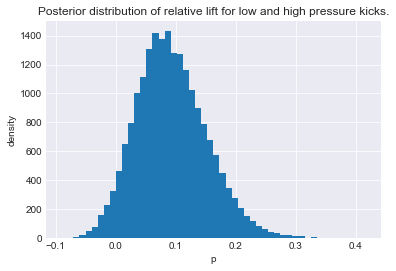

In [55]:
posterior_relative = (samples_posterior_low-samples_posterior_high)/samples_posterior_high
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of relative lift for low and high pressure kicks.')
print(int((posterior_relative>0.01).mean()*100), r'% likely relative lift of low over high pressure kicks greater than 1%.')

center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with a {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')